# Concentración de desventajas

En este tutorial vamos a usar el módulo `covariables` para estimar un índice de Concentración de desventajas en la escala de Colonia.

In [ ]:
from criminologia_cdmx.etl import *
from criminologia_cdmx.covariables import *
from criminologia_cdmx.modelos import *
import geopandas as gpd

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

## Variables del índice
Vamos a usar un índice, adaptado para México del de Sampson, que ha sido utilizado en varios artículos por Vilalta y co-autores.

Las variables del índice:

* Porcentaje de varones
* Porcentaje de población entre 15 y 29 años
* Porcentaje sin acceso a servicios de salud
* Número promedio de ocupantes por vivienda
* Porcentaje de hablantes de lengua indígena

Todas las variables están en tasas, pero no necesariamente todas van a venir ya calculadas (población entre 15 y 29), entonces, antes de pasar a tasas, vamos a calcular lo que necesitemos.

In [ ]:
diccionario = get_diccionario_censo()
censo = get_variables_censo()
agregado = agrega_en_unidades(censo, diccionario, agregacion='colonias')
agregado.head()

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,...,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,OCUPVIVPAR,PROM_OCUP_C
colonia_cve,,,,,,,,,,,,,,,,,,,,,
0,7232.0,3678.0,3554.0,246.0,99.0,117.0,6957.0,3550.0,3407.0,6739.0,...,1198.0,784.0,557.0,331.0,20.0,61.0,621.0,3.0,7149.0,1.417609
1,1957.0,1032.0,925.0,44.0,17.0,16.0,1909.0,1008.0,901.0,1874.0,...,434.0,266.0,168.0,135.0,0.0,11.0,146.0,0.0,1957.0,1.205049
2,3359.0,1794.0,1565.0,98.0,35.0,46.0,3253.0,1748.0,1505.0,3172.0,...,737.0,503.0,331.0,191.0,3.0,30.0,248.0,3.0,3359.0,1.204806
3,2330.0,1251.0,1079.0,46.0,8.0,23.0,2279.0,1233.0,1046.0,2231.0,...,691.0,475.0,369.0,200.0,3.0,3.0,104.0,0.0,2327.0,0.992747
4,4297.0,2277.0,2020.0,98.0,33.0,21.0,4186.0,2219.0,1967.0,4099.0,...,951.0,633.0,373.0,264.0,4.0,31.0,343.0,3.0,4297.0,1.177906


Para encontrar las variables que necesitamos, podemos usar el diccionario

In [ ]:
diccionario

,Indicador,Descripción,Nombre del Campo,Rangos,Longitud
0,Población total,Total de personas que residen habitualmente en...,POBTOT,0...999999999,9
1,Población femenina,Total de mujeres que residen habitualmente en ...,POBFEM,0...999999999,9
2,Población masculina,Total de hombres que residen habitualmente en ...,POBMAS,0...999999999,9
3,Población de 0 a 2 años,Personas de 0 a 2 años de edad.,P_0A2,0…999999999,9
4,Población femenina de 0 a 2 años,Mujeres de 0 a 2 años de edad.,P_0A2_F,"0.,.999999999",9
...,...,...,...,...,...
217,Viviendas particulares habitadas que disponen ...,Viviendas particulares habitadas que tienen co...,VPH_CVJ,0…999999999,9
218,Viviendas particulares habitadas sin radio ni ...,Viviendas particulares habitadas que no cuenta...,VPH_SINRTV,0…999999999,9
219,Viviendas particulares habitadas sin línea tel...,Viviendas particulares habitadas que no cuenta...,VPH_SINLTC,0…999999999,9
220,Viviendas particulares habitadas sin computado...,Viviendas particulares habitadas que no cuenta...,VPH_SINCINT,0…999999999,9


Busquemos la Población de 15 a 29, podemos empezar por ver todas las variables de rangos de población a ver cuál nos sirve

In [ ]:
diccionario[diccionario['Nombre del Campo'].str.startswith('P_')]

,Indicador,Descripción,Nombre del Campo,Rangos,Longitud
3,Población de 0 a 2 años,Personas de 0 a 2 años de edad.,P_0A2,0…999999999,9
4,Población femenina de 0 a 2 años,Mujeres de 0 a 2 años de edad.,P_0A2_F,"0.,.999999999",9
5,Población masculina de 0 a 2 años,Hombres de 0 a 2 años de edad.,P_0A2_M,0...999999999,9
6,Población de 3 años y más,Personas de 3 a 130 años de edad.,P_3YMAS,0...999999999,9
7,Población femenina de 3 años y más,Mujeres de 3 a 130 años de edad.,P_3YMAS_F,0...999999999,9
8,Población masculina de 3 años y más,Hombres de 3 a 130 años de edad.,P_3YMAS_M,0...999999999,9
9,Población de 5 años y más,Personas de 5 a 130 años de edad.,P_5YMAS,0...999999999,9
10,Población femenina de 5 años y más,Mujeres de 5 a 130 años de edad.,P_5YMAS_F,0...999999999,9
11,Población masculina de 5 años y más,Hombres de 5 a 130 años de edad.,P_5YMAS_M,0...999999999,9
12,Población de 12 años y más,Personas de 12 a 130 años de edad.,P_12YMAS,0...999999999,9


Bueno, pues parece que lo más que podemos acercarnos es la suma de los de 15 a 17 con los de 18 a 24. Calculemos eso y guardemoslo en una columna. Si lo guardamos con un nombre que comience con P_, la función `censo_a_tasas` la va a reconocer automáticamente como variable de población y va a calcular la tasa bien.

In [ ]:
agregado['P_15A24'] = agregado['P_15A17'] + agregado['P_18A24']

También queremos la población masculina, esa sale muy fácil: POBMAS

Ahora vamos a buscar la variable de acceso a servicios de salud

In [ ]:
diccionario[diccionario['Indicador'].str.contains('salud')]

,Indicador,Descripción,Nombre del Campo,Rangos,Longitud
146,Población sin afiliación a servicios de salud,Total de personas que no están afiliadas a ser...,PSINDER,0...999999999,9
147,Población afiliada a servicios de salud,Total de personas que están afiliadas a servic...,PDER_SS,0...999999999,9
148,Población afiliada a servicios de salud en el ...,Total de personas que están afiliadas a servic...,PDER_IMSS,0...999999999,9
149,Población afiliada a servicios de salud en el ...,Total de personas que están afiliadas a servic...,PDER_ISTE,0...999999999,9
150,Población afiliada a servicios de salud en el ...,Total de personas que están afiliadas a servic...,PDER_ISTEE,0...999999999,9
151,Población afiliada a servicios de salud en PEM...,Total de personas que están afiliadas a servic...,PAFIL_PDOM,0...999999999,9
152,Población afiliada a servicios de salud en el ...,Total de personas que están afiliadas a servic...,PDER_SEGP,0...999999999,9
153,Población afiliada a servicios de salud en el ...,Total de personas que están afiliadas a servic...,PDER_IMSSB,0...999999999,9
154,Población afiliada a servicios de salud en una...,Total de personas que están afiliadas a servic...,PAFIL_IPRIV,0...999999999,9
155,Población afiliada a servicios de salud en otr...,Total de personas que están afiliadas a servic...,PAFIL_OTRAI,0...999999999,9


Definitivamente PSINDER es lo que andamos buscando, no hay que calcular nada.

Vamos ahora a ver dónde está el número de habitantes por vivienda.

In [ ]:
diccionario[diccionario['Indicador'].str.contains('vivienda')]

,Indicador,Descripción,Nombre del Campo,Rangos,Longitud
169,Total de viviendas,"Viviendas particulares habitadas, deshabitadas...",VIVTOT,0...999999999,9
170,Total de viviendas habitadas,Viviendas particulares y colectivas habitadas....,TVIVHAB,0...999999999,9
171,Total de viviendas particulares,"Viviendas particulares habitadas, deshabitadas...",TVIVPAR,0...999999999,9
173,Total de viviendas particulares habitadas con ...,Viviendas particulares habitadas a las que se ...,VIVPARH_CV,0...999999999,9
174,Total de viviendas particulares habitadas,Viviendas particulares habitadas de cualquier ...,TVIVPARHAB,0...999999999,9
177,Ocupantes en viviendas particulares habitadas,Personas que residen en viviendas particulares...,OCUPVIVPAR,0...99999999,9
178,Promedio de ocupantes en viviendas particulare...,Resultado de dividir el número de personas que...,PROM_OCUP,0...999999999,9
179,Promedio de ocupantes por cuarto en viviendas ...,Resultado de dividir el número de personas que...,PRO_OCUP_C,0...999999999,9
189,Viviendas particulares habitadas que disponen ...,Viviendas particulares habitadas que tienen di...,VPH_AGUADV,0…999999999,9
191,Viviendas particulares habitadas que no dispon...,Viviendas particulares habitadas que no tienen...,VPH_AGUAFV,0…999999999,9


Perfecto, PROM_OCUP	 es lo que andamos buscando. Ya sólo nos falta localizar la variable de hablantes de lengua indígena.

In [ ]:
diccionario[diccionario['Indicador'].str.contains('indígena')]

,Indicador,Descripción,Nombre del Campo,Rangos,Longitud
60,Población de 3 años y más que habla alguna len...,Personas de 3 a 130 años de edad que hablan al...,P3YM_HLI,0...999999999,9
61,Población femenina de 3 años y más que habla a...,Mujeres de 3 a 130 años de edad que hablan alg...,P3YM_HLI_F,0...999999999,9
62,Población masculina de 3 años y más que habla ...,Hombres de 3 a 130 años de edad que hablan alg...,P3YM_HLI_M,0...999999999,9
63,Población de 3 años y más que habla alguna len...,Personas de 3 a 130 años de edad que hablan al...,P3HLINHE,0...999999999,9
64,Población femenina de 3 años y más que habla a...,Mujeres de 3 a 130 años de edad que hablan alg...,P3HLINHE_F,0...999999999,9
65,Población masculina de 3 años y más que habla ...,Hombres de 3 a 130 años de edad que hablan alg...,P3HLINHE_M,0...999999999,9
66,Población de 3 años y más que habla alguna len...,Personas de 3 a 130 años de edad que hablan al...,P3HLI_HE,0...999999999,9
67,Población femenina de 3 años y más que habla a...,Mujeres de 3 a 130 años de edad que hablan alg...,P3HLI_HE_F,0...999999999,9
68,Población masculina de 3 años y más que habla ...,Hombres de 3 a 130 años de edad que hablan alg...,P3HLI_HE_M,0...999999999,9
69,Población de 5 años y más que habla alguna len...,Personas de 5 a 130 años de edad que hablan al...,P5_HLI,0...999999999,9


Usemos P3YM_HLI: Población de 3 años y más que habla alguna lengua indígena.
es

Ahora podemos entonces construir una lista con nuestras variables. Nos traemos también POBTOT y  VIVPAR_HAB para poder estimar tasas.


In [ ]:
vars_indice = ['POBTOT', 'VIVPAR_HAB', 'POBMAS', 'P_15A24', 'PSINDER', 'PROM_OCUP', 'P3YM_HLI']
agregado = agregado.loc[:, vars_indice]
agregado.head()

,POBTOT,VIVPAR_HAB,POBMAS,P_15A24,PSINDER,PROM_OCUP,P3YM_HLI
colonia_cve,,,,,,,
0,7232.0,1825.0,3554.0,1224.0,2117.0,3.917260,251.0
1,1957.0,607.0,925.0,266.0,496.0,3.224053,7.0
2,3359.0,1030.0,1565.0,447.0,722.0,3.261165,39.0
3,2330.0,803.0,1079.0,279.0,497.0,2.897883,7.0
4,4297.0,1347.0,2020.0,603.0,855.0,3.190052,37.0


Pasamos a tasas

In [ ]:
tasas = censo_a_tasas(agregado, diccionario)
tasas

,POBTOT,VIVPAR_HAB,POBMAS,P_15A24,PSINDER,PROM_OCUP,P3YM_HLI
colonia_cve,,,,,,,
0,7232.0,1825.0,0.491427,0.169248,0.292727,3.917260,0.034707
1,1957.0,607.0,0.472662,0.135922,0.253449,3.224053,0.003577
2,3359.0,1030.0,0.465912,0.133075,0.214945,3.261165,0.011611
3,2330.0,803.0,0.463090,0.119742,0.213305,2.897883,0.003004
4,4297.0,1347.0,0.470095,0.140330,0.198976,3.190052,0.008611
...,...,...,...,...,...,...,...
1811,2603.0,639.0,0.487514,0.167115,0.324625,4.073552,0.002305
1812,889.0,259.0,0.479190,0.182227,0.233971,3.432432,0.003375
1813,3341.0,628.0,0.471715,0.150853,0.187968,4.880573,0.014068


Ahora podemos calcular un índice basado en PCA sobre las variables que nos interesan

In [ ]:
vars_indice = ['POBMAS', 'P_15A24', 'PSINDER', 'PROM_OCUP', 'P3YM_HLI']
indice = IndicePCA(tasas, vars_indice)
indice.calcula_indice()
print(indice.varianza_explicada)

[0.48391851]


Podemos fácilmente hacer un mapa del índice

<AxesSubplot: >

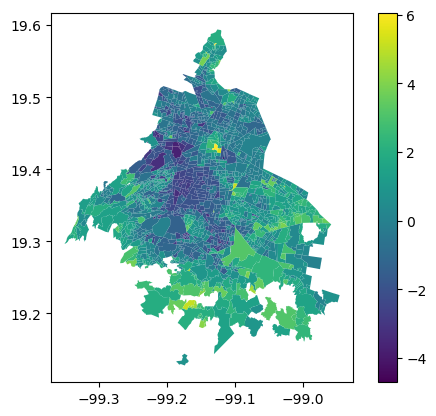

In [ ]:
colonias = gpd.read_file(DATA_PATH/"criminologia_capas.gpkg", layer='colonias')
colonias = colonias.merge(indice.indice, on='colonia_cve')
colonias.plot('Índice', legend=True)

## Bonus: Unas variables extra

Vamos a hacer una base de datos con las variables originales más densidad de población

In [ ]:
colonias = gpd.read_file(DATA_PATH/"criminologia_capas.gpkg", layer='colonias')
colonias = colonias.merge(agregado, on='colonia_cve')
colonias

,colonia_cve,colonia_nombre,municipio_cvegeo,geometry,POBTOT,VIVPAR_HAB,POBMAS,P_15A24,PSINDER,PROM_OCUP,P3YM_HLI
0,1,AGUILERA,None,"MULTIPOLYGON (((-99.15901 19.47374, -99.15882 ...",1957.0,607.0,925.0,266.0,496.0,3.224053,7.0
1,2,ALDANA,None,"MULTIPOLYGON (((-99.14858 19.47156, -99.14863 ...",3359.0,1030.0,1565.0,447.0,722.0,3.261165,39.0
2,3,ANGEL ZIMBRON,None,"MULTIPOLYGON (((-99.19044 19.47144, -99.18996 ...",2330.0,803.0,1079.0,279.0,497.0,2.897883,7.0
3,4,ARENAL,None,"MULTIPOLYGON (((-99.15187 19.46803, -99.15186 ...",4297.0,1347.0,2020.0,603.0,855.0,3.190052,37.0
4,5,CENTRO DE AZCAPOTZALCO,None,"MULTIPOLYGON (((-99.18941 19.48515, -99.18933 ...",3151.0,1050.0,1466.0,424.0,752.0,2.990476,16.0
...,...,...,...,...,...,...,...,...,...,...,...
1796,1811,VILLA PROGRESISTA,None,"MULTIPOLYGON (((-99.24369 19.35705, -99.24358 ...",2603.0,639.0,1269.0,435.0,845.0,4.073552,6.0
1797,1812,VILLA SOLIDARIDAD,None,"MULTIPOLYGON (((-99.21857 19.38285, -99.21851 ...",889.0,259.0,426.0,162.0,208.0,3.432432,3.0
1798,1813,VILLA VERDUN,None,"MULTIPOLYGON (((-99.25629 19.34239, -99.25639 ...",3341.0,628.0,1576.0,504.0,628.0,4.880573,47.0
1799,1814,ZENON DELGADO,None,"MULTIPOLYGON (((-99.21591 19.39240, -99.21585 ...",2188.0,478.0,1062.0,319.0,637.0,4.577406,0.0


In [ ]:
colonias['area'] = colonias.to_crs(32614).area
colonias['Dens_Pob'] = colonias['POBTOT'].div(colonias['area'])
colonias


,colonia_cve,colonia_nombre,municipio_cvegeo,geometry,POBTOT,VIVPAR_HAB,POBMAS,P_15A24,PSINDER,PROM_OCUP,P3YM_HLI,area,Dens_Pob
0,1,AGUILERA,None,"MULTIPOLYGON (((-99.15901 19.47374, -99.15882 ...",1957.0,607.0,925.0,266.0,496.0,3.224053,7.0,103840.260738,0.018846
1,2,ALDANA,None,"MULTIPOLYGON (((-99.14858 19.47156, -99.14863 ...",3359.0,1030.0,1565.0,447.0,722.0,3.261165,39.0,154811.632103,0.021697
2,3,ANGEL ZIMBRON,None,"MULTIPOLYGON (((-99.19044 19.47144, -99.18996 ...",2330.0,803.0,1079.0,279.0,497.0,2.897883,7.0,241940.421077,0.009630
3,4,ARENAL,None,"MULTIPOLYGON (((-99.15187 19.46803, -99.15186 ...",4297.0,1347.0,2020.0,603.0,855.0,3.190052,37.0,286196.280908,0.015014
4,5,CENTRO DE AZCAPOTZALCO,None,"MULTIPOLYGON (((-99.18941 19.48515, -99.18933 ...",3151.0,1050.0,1466.0,424.0,752.0,2.990476,16.0,424115.575774,0.007430
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,1811,VILLA PROGRESISTA,None,"MULTIPOLYGON (((-99.24369 19.35705, -99.24358 ...",2603.0,639.0,1269.0,435.0,845.0,4.073552,6.0,94022.464730,0.027685
1797,1812,VILLA SOLIDARIDAD,None,"MULTIPOLYGON (((-99.21857 19.38285, -99.21851 ...",889.0,259.0,426.0,162.0,208.0,3.432432,3.0,29922.553902,0.029710
1798,1813,VILLA VERDUN,None,"MULTIPOLYGON (((-99.25629 19.34239, -99.25639 ...",3341.0,628.0,1576.0,504.0,628.0,4.880573,47.0,641250.343004,0.005210
1799,1814,ZENON DELGADO,None,"MULTIPOLYGON (((-99.21591 19.39240, -99.21585 ...",2188.0,478.0,1062.0,319.0,637.0,4.577406,0.0,107435.587319,0.020366


Ahora vamos a unir en un solo GeoDataFrame los datos absolutos, con los datos en tasas (y la vamos a poner el sufijo tasas)

In [ ]:
colonias = colonias.merge(tasas[vars_indice], on='colonia_cve', suffixes=('_abs', '_tasa'))
colonias

,colonia_cve,colonia_nombre,municipio_cvegeo,geometry,POBTOT,VIVPAR_HAB,POBMAS_abs,P_15A24_abs,PSINDER_abs,PROM_OCUP_abs,P3YM_HLI_abs,area,Dens_Pob,POBMAS_tasa,P_15A24_tasa,PSINDER_tasa,PROM_OCUP_tasa,P3YM_HLI_tasa
0,1,AGUILERA,None,"MULTIPOLYGON (((-99.15901 19.47374, -99.15882 ...",1957.0,607.0,925.0,266.0,496.0,3.224053,7.0,103840.260738,0.018846,0.472662,0.135922,0.253449,3.224053,0.003577
1,2,ALDANA,None,"MULTIPOLYGON (((-99.14858 19.47156, -99.14863 ...",3359.0,1030.0,1565.0,447.0,722.0,3.261165,39.0,154811.632103,0.021697,0.465912,0.133075,0.214945,3.261165,0.011611
2,3,ANGEL ZIMBRON,None,"MULTIPOLYGON (((-99.19044 19.47144, -99.18996 ...",2330.0,803.0,1079.0,279.0,497.0,2.897883,7.0,241940.421077,0.009630,0.463090,0.119742,0.213305,2.897883,0.003004
3,4,ARENAL,None,"MULTIPOLYGON (((-99.15187 19.46803, -99.15186 ...",4297.0,1347.0,2020.0,603.0,855.0,3.190052,37.0,286196.280908,0.015014,0.470095,0.140330,0.198976,3.190052,0.008611
4,5,CENTRO DE AZCAPOTZALCO,None,"MULTIPOLYGON (((-99.18941 19.48515, -99.18933 ...",3151.0,1050.0,1466.0,424.0,752.0,2.990476,16.0,424115.575774,0.007430,0.465249,0.134560,0.238654,2.990476,0.005078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,1811,VILLA PROGRESISTA,None,"MULTIPOLYGON (((-99.24369 19.35705, -99.24358 ...",2603.0,639.0,1269.0,435.0,845.0,4.073552,6.0,94022.464730,0.027685,0.487514,0.167115,0.324625,4.073552,0.002305
1797,1812,VILLA SOLIDARIDAD,None,"MULTIPOLYGON (((-99.21857 19.38285, -99.21851 ...",889.0,259.0,426.0,162.0,208.0,3.432432,3.0,29922.553902,0.029710,0.479190,0.182227,0.233971,3.432432,0.003375
1798,1813,VILLA VERDUN,None,"MULTIPOLYGON (((-99.25629 19.34239, -99.25639 ...",3341.0,628.0,1576.0,504.0,628.0,4.880573,47.0,641250.343004,0.005210,0.471715,0.150853,0.187968,4.880573,0.014068
1799,1814,ZENON DELGADO,None,"MULTIPOLYGON (((-99.21591 19.39240, -99.21585 ...",2188.0,478.0,1062.0,319.0,637.0,4.577406,0.0,107435.587319,0.020366,0.485375,0.145795,0.291133,4.577406,0.000000


In [ ]:
colonias.to_file(DOWNLOADS_PATH/"colonias_vars_indice.shp")

/tmp/ipykernel_28904/3997562497.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  colonias.to_file(DOWNLOADS_PATH/"colonias_vars_indice.shp")
